# Introduction

Les algorithmes de partitionnement sont utilisés dans de nombreux domaines, tels que la reconnaissance de formes ou l'analyse d'images. Parmi les solutions en classification non supervisée, nous avons choisi de nous focaliser sur l'algorithme de propagation d'affinité (Affinity Propagation). Le fonctionnement de cet algorithme est décrit dans la suite.

Dans le cadre du traitement de données massives, la distribution et la parallélisation des calculs est essentielle. Nous avons utilisé le modèle de programmation Map Reduce pour développer un algorithme de propagation d'affinité. Nous nous sommes basés sur les articles [1] et [2]. L'algorithme a été testé sur un petit jeu de données simulées, avant d'être appliqué sur un cas pratique d'analyse d'image, comme cela a pu être fait dans l'article [3] avec un algorithme dérivé de la propagation d'affinité. Dans un premier temps nous avons essayé de faire l'algorithme entièrement en MapReduce, itérations comprises. Cependant ceci ne permet pas du tout d'optimiser le temps de calcul. Nous avons donc dans un deuxième temps essayé de reproduire l'article [1], c'est-à-dire distribuer l'algorithme de propagation avec des mappers. Les résultats et réflexions accompagnant ce projet sont intégrés dans ce notebook.

# Références

[1] Wei-Chih Hung, Chun-Yen Chu, and Yi-Leh Wu. **Map/Reduce Affinity Propagation Clustering Algorithm**.

[2] Yancheng He, Qingcai Chen, Xiaolong Wang, Ruifeng Xu, Xiaohua Bai, Xianjun Meng. **An Adaptive Affinity Propagation Document Clustering**.

[3] DILLON MARK ROSE, JEAN MICHEL ROULY, RANA HABER, NENAD MIJATOVIC, ADRIAN M. PETER. **PARALLEL HIERARCHICAL AFFINITY PROPAGATION WITH MAPREDUCE**

# Plan

# 0 Organisation du code dans le GitHub

# 1. Propagation d'affinité
   ## Principe
   ## Equations
# 2. Implémentation avec itérations MapReduce
   ## Pseudo-code
   ## Test sur petit jeu de données
   ## Test sur analyse d'images
   ## Problèmes de l'algorithme
# 3. Implémentation avec mappers indépendants et reduce
   ## Fonctionnement
   ## Cluster d'image avec les mappers
   ## Ajout des reducers

# 0. Organisation du code

Pour la première partie de ce notebook, c'est-à-dire la tentative de coder l'algorithme avec ses itérations entièrement en MapReduce, les fichiers concernés sont :
- spark_config.py : contient principalement un SparkContext.getOrCreate, pour éviter les problèmes de multiples contextes
- util.py : contient des fonctions qui peuvent être utiles dans toutes les fonctions des autres fichiers
- similarity.py : contient l'algo de calcul de la matrice de similarité en MapReduce
- updates.py : contient les fonctions d'update des matrices de disponibilités et responsabilités (cf. partie 1 description de l'algorithme)
- cluster.py : contient la fonction globale qui utilise similarity, updates et trouve les clusters

Pour la seconde partie, le code utilisé provient du fichier cluster_pure_python.py, et la distribution des calculs en utilisant du MapReduce avec les fonctions de ce fichier .py est codée directement dans le notebook.

# 1. Propagation d'affinité

## Principe

La classification non supervisée repose sur la création de groupes avec une homogénéité intra forte, et une hétérogénéité entre les groupes. Dans notre cas, nous cherchons des "exemples" pour les points, qui vont servir de représentants pour les autres points de par leur similarité. Cette similarité entre points se basent sur une fonction de distance. Pour simplifier, nous prenons ici la distance euclidienne, que nous utilisons pour des variables quantitatives et non catégorielles. Dans le cas de la propagation d'affinité, des messages de responsabilité (responsibility) et de disponibilité (availability) sont échangés entre tous les points.

La responsabilité r(i,j) représente à quel point le point j est adapté pour servir d'exemple au point i. La disponibilité a(i,j) représente à quel point il est adéquat pour le point i de prendre en exemple le point j. Ces deux notions sont figurées dans le schéma suivant.

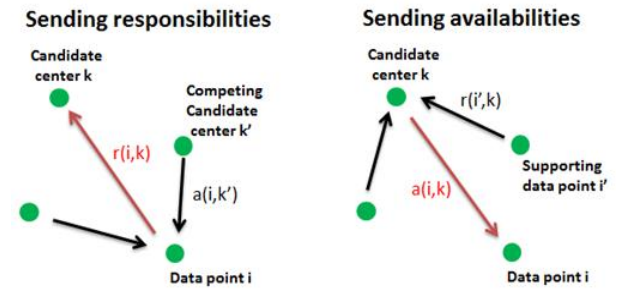

In [12]:
from IPython.display import Image
Image(filename='Images/messages.png')

Ces messages sont mis à jour sur plusieurs itérations, en se basant sur une matrice de similarité calculée en début d'algorithme, avec comme mesure de similarité l'opposé de la distance euclidienne, soit pour deux points i et j ayant pour valeurs respectivement les vecteurs $x_i$ et $x_j$:

$$d(i,j)=-||x_i-x_j||^2$$

La diagonale de cette matrice correspond aux préférences, qui sont nulles si l'on utilise cette distance euclidienne. Les auteurs utilisent une préférence s(i,i) identique pour tous les points i et qui est calculée selon un algorithme décrit dans les parties suivantes. Les systèmes de mise à jour des messages y seront également décrits.

Pour finir, après plusieurs itérations, nous obtenons les exemples finaux obtenus en maximisant la somme de la responsabilité et de la disponibilité pour chacun des points.

## Equations de mise à jour des messages

Trois équations sont utilisées pour mettre à jour les messages à partir des messages de l'étape précédente et de la matrice de similarité. Pour éviter de trop grandes oscillations numériques, chaque message est mis à jour en utilisant une constante $\lambda$ (par défaut 0.5) de la façon suivante, avec les valeurs mises à jour en utilisant les équations (1), (2) et (3) : _nouvelle valeur = (1-$\lambda$) \* valeur mise à jour + $\lambda$ \* ancienne valeur_.  

$$ r(i,k) \leftarrow s(i,k) - \max_{k' \neq k} (a(i,k')+s(i,k')) \quad \quad (1) $$

$$ a(i,k) \leftarrow \min \left( 0, \ r(k,k) + \sum_{i' \neq i,k} max(0,r(i',k)) \right) \quad \quad (2) $$

$$ a(k,k) \leftarrow \sum_{i' \neq k} max(0,r(i',k) \quad \quad (3) $$

## Equations pour le calcul/la mise à jour des préférences

L'article utilisé pour cette partie est l'article [2], l'article [1] étant peu clair sur le choix des préférences. La préférence est mise à jour à chaque itération selon ($***$), et nommée $P_{step}$. Elle est calculée par rapport à $P_{min}$ ($*$), $P_{max}$ ($**$), le nombre d'observations et le nombre de clusters de l'étape. Les équations sont données ci-dessous.

$$ P_{max} = \max_{i \neq k} (s(i,k)) \quad \quad (*) $$

$$ P_{min} = \max_{i} (\sum_j s(i,j)) - \max_{i \neq j} (\sum_k \max(s(i,j),s(j,k))) \quad \quad (**) $$

$$ P_{step} = \dfrac{P_{max} - P_{min}}{N * 0.1 * \sqrt{K+50}} \quad \quad (***)$$


# 2. Implémentation de l'algorithme avec itérations en MapReduce

## Pseudo-code

Nous nous basons sur les pseudo-codes de l'article [2] pour bâtir notre algorithme, avec pour structure ce qui suit.

### Matrice de similarité et préférences, initialisation

- Calcul de la matrice de similarité avec la distance euclidienne

- Calcul des préférences

    - Calcul de Pmin
    - Calcul de Pmax
    - Calcul de Pstep
    
- Initialisation des disponibilités à zéro

### Itérations

- for (i in 1:nombre d'itérations):
    - Mise à jour des responsabilités à partir des similarités et des disponibilités
    - Mise à jour des disponibilités à partir des responsabilités mises à jour
    - Calcul des nouveaux clusters => nombre de clusters
    - Mise à jour de $P_{step}$ avec le nouveau nombre de clusters
    
- return clusters

**-------------------------------------------------------------------------------------------------------------------------------**

Un fichier contient les fonctions de mise à jour des messages, un autre des fonctions utiles pour tous les modules, un autre permet de configurer SparkContext, et enfin un fichier global permet de gérer le clustering dans son ensemble.

Nous travaillons avec des RDD et un système de clé-valeurs. Ainsi, par exemple pour la matrice de similarités, les clés sont les couples (i,j) représentant les index des observations des deux points comparés, et la valeur est leur similarité associée. Le format des clés changent selon l'opération à effectuer pour les différentes équations présentées plus haut. Nous ne détaillerons pas ici les mappers et reducers utilisés dans l'algorithme. Nous donnons juste ci-dessous l'exemple pour le calcul de la matrice de similarités (hors calcul des préférences).

### MapReduce pour le calcul des similarités

L'input est une matrice des observations : chaque ligne, qui correspond à une observation, contient les p variables associées à l'observation. Chaque ligne est indexée. De même chaque colonne est indexée, ce qui nous permet de convertir la matrice en un RDD dont les clés sont les tuples (index de l'observation, index de la variable) et les valeurs sont les valeurs des variables associées (cf. TP matrice 3 colonnes).

Pour calculer les similarités, nous devons calculer les écarts entre chaque variable pour toutes les paires d'individus. Nous changeons donc la structure du RDD pour avoir en clé l'index de la variable, et en valeurs les tuples ((index de l'observation i, valeur de la variable pour l'observation i), (index de l'observation j, valeur de la variable pour l'observation j)). Nous utilisons un mapper pour calculer la distance pour chaque ligne du RDD. Nous pouvons alors rechanger le système de clés pour obtenir une clé (index de l'observation i, index de l'observation j), associées chacune aux distances. Un reduceByKey permet de sommer toutes les distances entre deux observations pour l'ensemble de leurs variables. La matrice des similarités prend donc la forme [(i,j), similarité entre i et j] pour chaque ligne.

Nous avons testé la justesse de la fonction de calcul des similarités programmée en MapReduce en la comparant à une fonction programmée en Python simplement.

In [34]:
#### Similarity matrix with pure Python
from cluster_pure_python import *

#### Test ####
import pandas
import numpy as np
from numpy.random import rand
mat1=np.array([[3,3,3],[2,2,2],[1,1,1]])
df1 = pandas.DataFrame(mat1)
df1.to_csv("data/mat1.txt", sep="\t",header=None,index=True)

similatry_matrix(mat1)

Iteration Similarity 0


array([[ -0.,  -3., -12.],
       [ -3.,  -0.,  -3.],
       [-12.,  -3.,  -0.]])

In [8]:
# Similarity matrix using MapReduce
from similarity import * # import functions to compute similarity in MapReduce, see similarity.py
mat_sim=similarity_matrix("data/mat1.txt")
result=sorted(mat_sim.collect())
print(result)

[((0, 0), -0.0), ((0, 1), -3.0), ((0, 2), -12.0), ((1, 0), -3.0), ((1, 1), -0.0), ((1, 2), -3.0), ((2, 0), -12.0), ((2, 1), -3.0), ((2, 2), -0.0)]


Nous retrouvons bien des résultats cohérents avec le code purement Python.

## Test de l'algorithme sur un petit jeu de données simulées

Pour des données de petites dimensions, l'utilisation de MapReduce n'est pas intéressante. Nous testons simplement que notre algorithme tourne sur un jeu de données simulées de petite dimension.

Spark utilise un système de « lazy evaluation », Spark ne créera vraiment les RDD qu'en cas d'action. Pour empêcher Spark de recalculer le RDD à chaque fois, on peut forcer Spark à le sauvegarder en mémoire en utilisant cache() ou  persist() (cette dernière fonction permet de paramétrer le niveau de mémorisation).

In [9]:
from cluster import *
clusters=algo_cluster("data/mat1.txt",3,nb_iter=2)

Clustering in map_reduce
Similarity matrix computed
Initializing preferences...
Preferences initialized.
Matrices initialized
----------------------------------------------
Itération 1
R and A updated
Computing clusters...
Clusters updated.
Updating preferences...
3
Preferences updated
290.1742763519287 sec
----------------------------------------------
Itération 2
R and A updated
Computing clusters...
Clusters updated.
Updating preferences...
3
Preferences updated
1344.0183327198029 sec


On peut voir que sur ce petit exemple, on a un problème de temps de computation. Nous essayons de limiter ce phénomène en empêchant le recalcul, en utilisant cache(). Cependant cela ne résoud pas le problème. Nous essayons en utilisant collect() et en reparallélisant les RDD que l'on ne souhaite pas recalculer. En effet, l'idée est que si la deuxième itération est aussi longue, on peut supposer qu'elle recommence les actions de l'initialisation et de la première itération en plus de celles spécifiques à son cas. Mais on retombe sur le même problème. En utilisant http://localhost:4040/jobs/, on cherche à savoir le job qui prend trop de temps. Au vu des graphiques ci-dessous, l'élément qui pose problème est le count() utilisé pour calculer le nombre de clusters qui permet d'updater la $P_{step}$, qui prend beaucoup de temps (c'est une action de type reduce), et en soi n'est pas essentiel dans notre algorithme : la mise à jour des préférences n'est pas faite dans l'article [1]. On utilise donc la $P_{step}$ initiale pour tout l'algorithme afin de voir si cela améliore les choses.

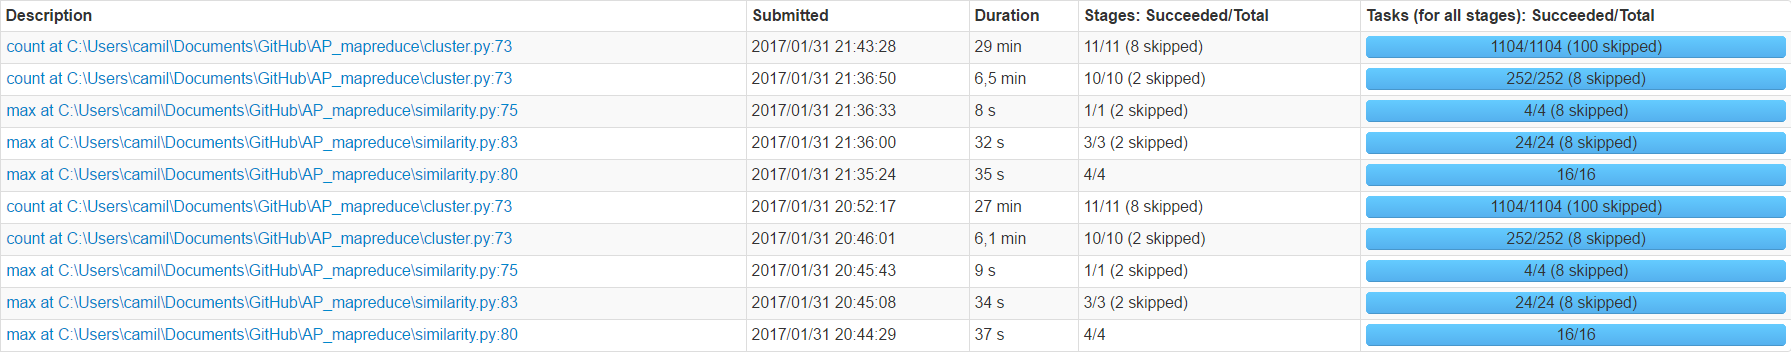

In [13]:
Image(filename='Images/Spark_Jobs.png')

In [14]:
from cluster import *
clusters=algo_cluster("mat1.txt",3,nb_iter=3,pref_update=False)

Clustering in map_reduce
Similarity matrix computed
Initializing preferences...
Preferences initialized.
Matrices initialized
----------------------------------------------
Itération 1
R and A updated
2.219947576522827 sec
----------------------------------------------
Itération 2
R and A updated
2.2537355422973633 sec
----------------------------------------------
Itération 3
R and A updated
2.2501862049102783 sec
Computing clusters...
Computed.


Cette fois-ci, le code s'exécute "rapidement" comme on le souhaite. Cependant, nous n'avons pas fait d'action sur les RDD issus de l'algorithme, qui sont tous rassemblés dans l'étape finale de clustering. Cela risque d'être très long, puisque toutes les actions se réaliseront à la fin. Par ailleurs, l'étape de computation de la matrice de similarité en elle-même reste quelque peu longue (plusieurs minutes pour une matrice très petite). Nous passons à l'application sur les images pour tester le code sur des données plus conséquentes.

## AffinityPropagation sur une image

Une image est en fait une matrice d'observations dont les caractéristiques sont 3 entiers RGB. Nous pouvons appliquer l'algorithme développé sur des images de taille conséquente. C'est ce qu'ont fait certains auteurs en utilisant la propagation d'affinité, comme.... Nous souhaitons tester l'algorithme sur ce même exercice. L'idée est de trouver les clusters et reconstruire l'image en associant la couleur de l'exemple aux points qui l'ont pris pour exemple.

In [9]:
%matplotlib inline

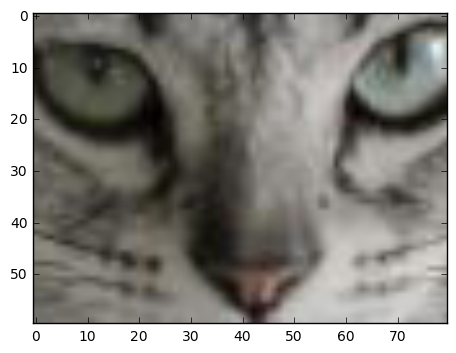

In [10]:
from scipy import misc
face = misc.imread('Images/chat.png')
face=face[90:150,60:140]
import matplotlib.pyplot as plt
plt.imshow(face, cmap=plt.cm.gray, vmin=30, vmax=200)

In [11]:
import numpy as np
import pandas
dims=face.shape
# on reformate de manière à avoir une suite de points qui forment une suite de lignes
# on pourra reconstituer l'image puisque l'on connait les dimensions et que l'ordre des points est conservé
data=np.reshape(face,(dims[0]*dims[1],dims[2]))
df=pandas.DataFrame(data)
df.to_csv("data/face_dataset.txt", sep="\t",header=None,index=True)
print(dims)

(60, 80, 3)


In [18]:
from cluster import *
results=algo_cluster("data/face_dataset.txt",dims[0]*dims[1],nb_iter=10,pref_update=False)

Clustering in map_reduce
Similarity matrix computed
Initializing preferences...


KeyboardInterrupt: 

## Limites de l'algorithme implémenté

### Matrice de similarités

On n'arrive pas à faire tourner l'algorithme complet. Des erreurs pour les kernels apparaissent, des problèmes avec les connecteurs Python, etc., dus à des problèmes de taille de disque, les jobs sont trop longs et consomment des Go de mémoire (usuellement jusqu'au remplissage complet du disque, ici on a arrêté avant). L'étape problématique est l'étape de création de la matrice de similarités. On va donc faire cette étape hors MapReduce, et donner la matrice des similarités en tant qu'input aux itérations de clustering afin de voir si le reste fonctionne bien.

### Problème des itérations

Avec les itérations, si l'on lance le collect à la fin, les RDDs à mettre à jour vont réeffectuer les calculs de l'itération 1 à k pour l'étape k, ce qui pose problème, on ajoute donc des rdd.cache() à chaque itération pour que les RDDs soient persistents. Nous ne sommes cependant pas sûrs que cela fonctionne, du fait entre autres de la taille limite de la RAM.

In [23]:
SM=similatry_matrix(data)
import random
# on fixe une préférence pour tous
pref=random.randrange(-10,-500,-1)
print(pandas.DataFrame(SM).head())
np.fill_diagonal(SM,pref)
mat_sim=pandas.DataFrame(SM)
mat_sim.to_csv("data/mat_sim.txt", sep="\t",header=None,index=True)
mat_sim.head()

Iteration Similarity 0
Iteration Similarity 1000
Iteration Similarity 2000
Iteration Similarity 3000
Iteration Similarity 4000
       0         1         2      3         4         5         6     \
0      -0.0      -3.0    -147.0 -432.0  -65035.0     -83.0    -116.0   
1 -195075.0      -0.0    -108.0 -363.0  -64520.0     -56.0     -83.0   
2 -186003.0 -187500.0      -0.0  -75.0 -187508.0 -128020.0 -129035.0   
3 -178608.0 -180075.0 -189003.0   -0.0 -180083.0 -186011.0 -187508.0   
4 -129035.0  -64520.0    -116.0 -371.0      -0.0     -48.0     -75.0   

       7         8         9       ...        4790     4791      4792  \
0 -192035.0 -174251.0 -167096.0    ...    -78758.0 -96149.0 -114101.0   
1 -190520.0 -172808.0 -165683.0    ...    -77789.0 -95078.0 -112934.0   
2 -181556.0 -164276.0 -157331.0    ...    -72101.0 -88778.0 -106058.0   
3 -174251.0 -157331.0 -150536.0    ...    -67526.0 -83693.0 -100493.0   
4 -190512.0 -172800.0 -165675.0    ...    -77769.0 -95058.0 -112914.0   

 

,0,1,2,3,4,5,6,7,8,9,...,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799
0,-173.0,-3.0,-147.0,-432.0,-65035.0,-83.0,-116.0,-192035.0,-174251.0,-167096.0,...,-78758.0,-96149.0,-114101.0,-120026.0,-117638.0,-114101.0,-115274.0,-109469.0,-112934.0,-134858.0
1,-195075.0,-173.0,-108.0,-363.0,-64520.0,-56.0,-83.0,-190520.0,-172808.0,-165683.0,...,-77789.0,-95078.0,-112934.0,-118829.0,-116453.0,-112934.0,-114101.0,-108326.0,-111773.0,-133589.0
2,-186003.0,-187500.0,-173.0,-75.0,-187508.0,-128020.0,-129035.0,-181556.0,-164276.0,-157331.0,...,-72101.0,-88778.0,-106058.0,-111773.0,-109469.0,-106058.0,-107189.0,-101594.0,-104933.0,-126101.0
3,-178608.0,-180075.0,-189003.0,-173.0,-180083.0,-186011.0,-187508.0,-174251.0,-157331.0,-150536.0,...,-67526.0,-83693.0,-100493.0,-106058.0,-103814.0,-100493.0,-101594.0,-96149.0,-99398.0,-120026.0
4,-129035.0,-64520.0,-116.0,-371.0,-173.0,-48.0,-75.0,-190512.0,-172800.0,-165675.0,...,-77769.0,-95058.0,-112914.0,-118809.0,-116433.0,-112914.0,-114081.0,-108306.0,-111753.0,-133569.0


In [1]:
from cluster import *
S=sc.textFile("data/mat_sim.txt").flatMap(process_mat_row).map(lambda x: ((x[0],x[1]),x[2]))
A=S.map(initialize_avail)
A.cache()
R=None
nb_iter=5
print("Matrices initialized")
### Iterations ###
for n in range(0,nb_iter):
    print("----------------------------------------------",flush=True)
    time.sleep(1)
    time_dep=time.time()
    print("Itération "+str(n+1),flush=True)
    time.sleep(1) 
    # update responsibilty and availability
    R=update_responsibility(S,A,R)
    R.cache()
    #print(R.distinct().count(),flush=True)
    #time.sleep(1)
    A=update_availability(R,A)
    A.cache()
    #print(A.distinct().count(),flush=True)
    #time.sleep(1)
    print("R and A updated",flush=True)
    time.sleep(1)
    time_total=time.time()-time_dep
    print(str(time_total)+" sec",flush=True)
    time.sleep(1)

print("Computing clusters...",flush=True)
time.sleep(1)
clusters=get_clusters(R,A)
clusters.cache()
print("Computed.",flush=True)
time.sleep(1)

Matrices initialized
----------------------------------------------
Itération 1
R and A updated
2.681232213973999 sec
----------------------------------------------
Itération 2
R and A updated
2.2708332538604736 sec
----------------------------------------------
Itération 3
R and A updated
2.2815988063812256 sec
----------------------------------------------
Itération 4
R and A updated
2.2654788494110107 sec
----------------------------------------------
Itération 5
R and A updated
2.2840356826782227 sec
Computing clusters...
Computed.


In [ ]:
list_clusters=clusters.collect()

Coder entièrement l'algorithme de propagation d'affinité en MapReduce n'est finalement pas une bonne idée, trop d'opérations d'aggrégations et le problème des itérations font que même sur ce jeu de données simple on ne peut pas obtenir les résultats dans un temps satifsaisant (il faut 10 minutes pour 20 opérations sachant que Spark en prévoit près de 150000...). Nous implémentons donc l'algorithme de la même façon que l'article [1], c'est-à-dire en utilisant notre algorithme codé en python en divisant les données d'entrée et en utilisant un mapper qui réalise la propagation d'affinité sur chaque sous-ensemble de données.

# Propagation d'affinité : mapper en partitionnant les données par groupes d'individus et réduire les clusters

## Fonctionnement 

On préprocesse les données de manière à les diviser pour pouvoir mapper l'algorithme dessus. Le choix est fait de manière aléatoire. Etant donné que nos ordinateurs ne comportent que quatre coeurs, on va ici diviser en 4 les jeux de données. Chacun des quatre mappers réalise alors une propagation d'affinité de manière indépendante. Les points et leurs centres sont renvoyés, ce qui nous donne des clusters. Les résultats des mappers sont combinés. Deux clusters sont combinés si leurs centres sont proches.

Remarque : pour la matrice de similarité, pour éviter des durées trop longues de calcul, nous choisissons de prendre une préférence simple. En effet, il est dit dans l'article que l'on pourrait prendre n'importe quelle préférence, et ils utilisent la méthode de l'article [2] pour en choisir une mais ce n'est pas obligatoire. Dans l'article [3], cette préférence est encore choisie différemment, puisqu'elle est tirée aléatoirement. Nous prenons une préférence qui vaut la moitié de la similarité minimale.


Nous testons tout d'abord notre algorithme python (cluster_pure_python.py) sur un petit jeu de données, puis nous passons à l'algorithme en MapReduce.

### Test de l'algorithme en python

In [6]:
from cluster_pure_python import *

In [3]:
D=np.array([[1,1,1],[2,2,2],[3,3,3],[4,4,4]])
results=Final_Boucle(D,10)

Similarity
Iteration Similarity 0
Beginning of the Loop
number of loops: 10
Iteration Responsability 0
Iteration Avaibility 0
Iteration Responsability 10
Iteration Avaibility 10
End of Loop, searching center of clusters


In [4]:
results

array([1, 1, 2, 2], dtype=int64)

## Algorithme distribué en MapReduce

On reprend les données de l'image utilisée plus haut.

### Clustering avec Mapper, pas de Reduce

On pourrait penser à calculer les matrices de similarité au sein des mappers, ce qui évite de calculer des similarités entre points qui ne sont pas dans le même mapper. Cependant, puisque le critère qui permet de réduire le nombre de clusters repose sur la similarité entre les centres, qui proviennent de mappers différents, il nous faut en fait calculer la matrice de similarité globale avant de mapper, et la fournir en input des mappers. De plus, deux options s'offrent à nous, la calculer en MapReduce, mais on a vu dans la première partie que cela pouvait être long, ou utiliser la fonction purement python qu'on utilise déjà dans les mappers. On fait cela simplement ici, puisqu'on veut une matrice de similarités dans la fonction de clustering on fournit déjà les similarités au format matriciel donc on prend la fonction codée dans cluster_pure_python : similatry_matrix.

In [3]:
from cluster_pure_python import *

In [68]:
# test pour voir la longueur pour un sous-jeu de 1000 individus, puisqu'on va diviser avec une fonction de hash à 4 valeurs
import time
dep=time.time()
Final_Boucle(data[0:1000],9)
print(time.time()-dep)

Similarity
Iteration Similarity 0
Beginning of the Loop
number of loops: 9
Iteration Responsability 0
Iteration Avaibility 0
Iteration Responsability 1
Iteration Avaibility 1
Iteration Responsability 2
Iteration Avaibility 2
Iteration Responsability 3
Iteration Avaibility 3
Iteration Responsability 4
Iteration Avaibility 4
Iteration Responsability 5
Iteration Avaibility 5
Iteration Responsability 6
Iteration Avaibility 6
Iteration Responsability 7
Iteration Avaibility 7
Iteration Responsability 8
Iteration Avaibility 8
End of Loop, searching center of clusters
335.23002529144287


In [12]:
SIM=similatry_matrix(data)
pref=SIM.min()
np.fill_diagonal(SIM,pref)
mat_sim=pandas.DataFrame(SIM)
mat_sim.to_csv("data/cat_sim.txt", sep="\t",header=None,index=True)

Iteration Similarity 0
Iteration Similarity 1000
Iteration Similarity 2000
Iteration Similarity 3000
Iteration Similarity 4000


In [18]:
rdd=sc.textFile("data/face_dataset.txt").map(index_values).map(define_subgroup).groupByKey().flatMap(lambda x: do_AP(x,SIM)).groupByKey()
clusters=rdd.collect()

In [19]:
len(clusters)

2206

On a 2206 clusters sans faire de reduce, avec 50 itérations, et on essaye déjà d'afficher le résultat en image. Pour chaque centre, on attribue à ses points sa couleur, et on affiche l'image.

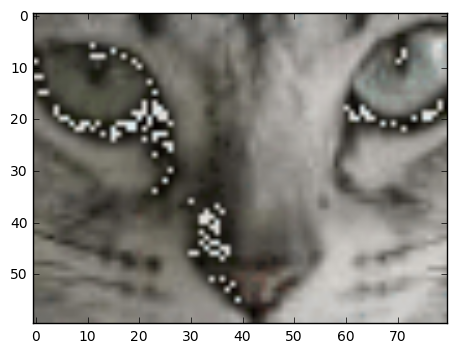

In [20]:
new_data=data.copy()
for element in clusters:
    index_center = element[0]
    data_center=new_data[index_center]
    index_points = list(element[1])
    for point in index_points:
        new_data[point]=data_center

new_data=np.reshape(new_data,(dims[0],dims[1],dims[2]))
plt.imshow(new_data, cmap=plt.cm.gray, vmin=30, vmax=200)

In [22]:
np.sum(new_data != face)/3 # on a bien modifié des points

2868.3333333333335

### Avec Reduce

Nous avons vu ci-dessus que nous nous retrouvons avec 3218 clusters, ce qui fait beaucoup, et cela ne nous a pas permis de simplifier l'image comme on le voit ci-dessus. L'étape de réduction va permettre de limiter le nombre de clusters.

Les reducers utilisés dans l'article [1] ne sont pas très clairs. Les exemples proches sont combinés, le seuil de proximité étant défini par la moitié de la préférence. Cependant, imaginons qu'on ait 3 exemples A, B, et C. La proximité de (A,B) et de (A,C) ne nous permet pas de regrouper les clusters des 3 points (A,B,C), puisque l'on ne sait pas si B et C sont éloignés. Faut-il alors regrouper (A,B) ou (A,C), ou (A,B,C) ? On choisit l'option 3 pour des raisons de simplicité. A partir du moment où A est proche de B et A est proche de C, on regroupe A, B, et C.

In [69]:
# Regrouper les centres voisins
def pair_key(row):
    i,j=row
    return (i,j),0

def find_near_centers(row,pref):
    (i,j), nu, s = row
    if s < 0.5*pref:
        return i,j

from cluster import *

In [79]:
exemplars = [c[0] for c in clusters]
exemplars = sc.parallelize(exemplars).map(lambda row: (0,row))

mat_sim = sc.textFile("data/mat_sim.txt").flatMap(process_mat_row).map(lambda x: ((x[0],x[1]),x[2])) 

near_exemplars =exemplars.join(exemplars)\
        .filter(lambda row: (row[1][0]!=row[1][1]))\
        .map(lambda row: (row[1][0],row[1][1]))\
        .map(pair_key)\
        .join(mat_sim)\
        .mapValues(lambda x: (x[0]+x[1]<0.5*pref))
        
near_exemplars.take(10)

if near_exemplars.count()>0:
    list_clusters_ex=near_exemplars.filter(lambda x: x)\
                    .map(lambda row: (row[0][0],row[1][0]))\
                    .groupByKey()\
                    .map(lambda row: list(row[0])+list(row[1]))
    # returns a RDD of lists of clusters' exemplars that are neighboring
    new_clusters=list_clusters_ex.collect()